In [1]:
from PyUoI.UoINMF import UoINMF
from activ import load_data, data_normalization
import os
from activ.readfile import TrackTBIFile
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
from activ.analytics import heatmap, nmf_bases_heatmap
from activ.clustering import UmapClusteringResults
from os.path import dirname, join
from scipy.optimize import curve_fit
from scipy.stats import norm, sem
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display, Latex, Markdown
from pylatex import Document, Section, Subsection, Command
from pylatex import Document, Section, Figure, SubFigure, NoEscape
from pylatex.utils import italic, NoEscape
from scipy.stats import norm, sem

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
nmfdata = load_data(uoinmf=True)
orig = load_data(uoinmf=False)
origoc = orig.outcomes
feature_names = nmfdata.biomarker_features
bmbases = nmfdata.biomarker_bases
bmbases.shape

(6, 235)

In [3]:
def drop_features(A,h,feature_names,percent):
    total_features = h.shape[1]
    num_features_to_drop = np.round(total_features*percent//100)
    h_sum = np.sum(h, axis=0)
    h_sum_sorted = np.argsort(h_sum)
    indices_lowest_values = h_sum_sorted[:num_features_to_drop]
    dropped_feature_names = sorted(feature_names[indices_lowest_values])
    h_new = np.delete(h, indices_lowest_values, axis=1)
    A_new = np.delete(A, indices_lowest_values, axis=1)    
    return A_new,h_new, dropped_feature_names

In [4]:
def get_biomarker_transformed_weight(dropped_bases,A):
    uoinmf = UoINMF()
    uoinmf.components_ = dropped_bases
    data = data_normalization.data_normalization(A, 'positive')
    W = uoinmf.transform(data)
    return W

In [5]:
percent = [0,10,20,30,40,50,60,70,80,90]
for p in percent:
    A_features_dropped, features_dropped, dropped_feature_names = drop_features(orig.biomarkers,bmbases,feature_names,p)
    w = get_biomarker_transformed_weight(features_dropped, A_features_dropped)
    print(A_features_dropped.shape, features_dropped.shape, w.shape)
    fname = '/Users/ahyeon/data/activ/bm_features_dropped/bm_features_dropped_{}.h5'.format(p)
    TrackTBIFile.write(fname, w, origoc)
    

(247, 235) (6, 235) (247, 6)
(247, 212) (6, 212) (247, 6)
(247, 188) (6, 188) (247, 6)
(247, 165) (6, 165) (247, 6)
(247, 141) (6, 141) (247, 6)
(247, 118) (6, 118) (247, 6)
(247, 94) (6, 94) (247, 6)
(247, 71) (6, 71) (247, 6)
(247, 47) (6, 47) (247, 6)
(247, 24) (6, 24) (247, 6)


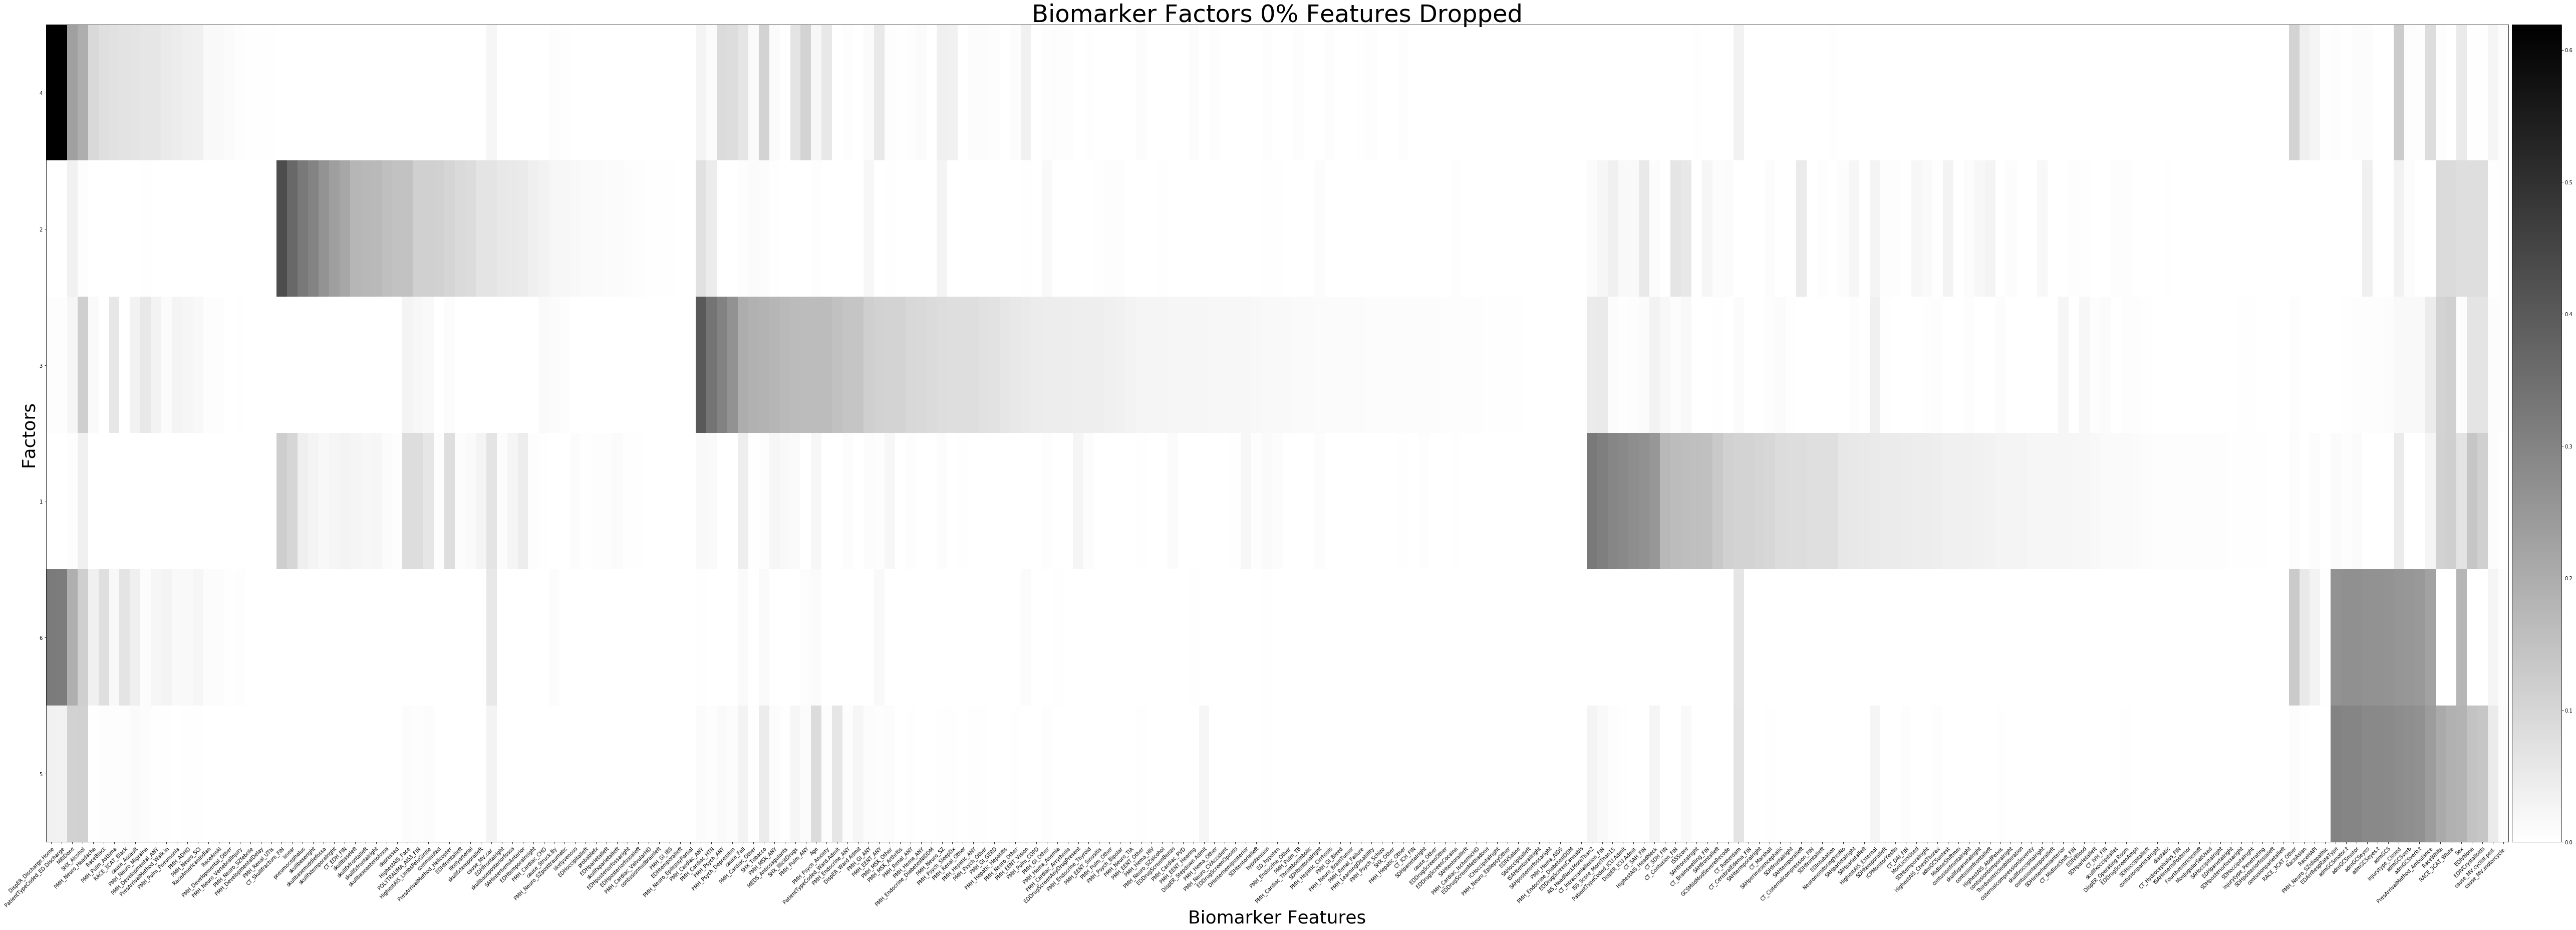

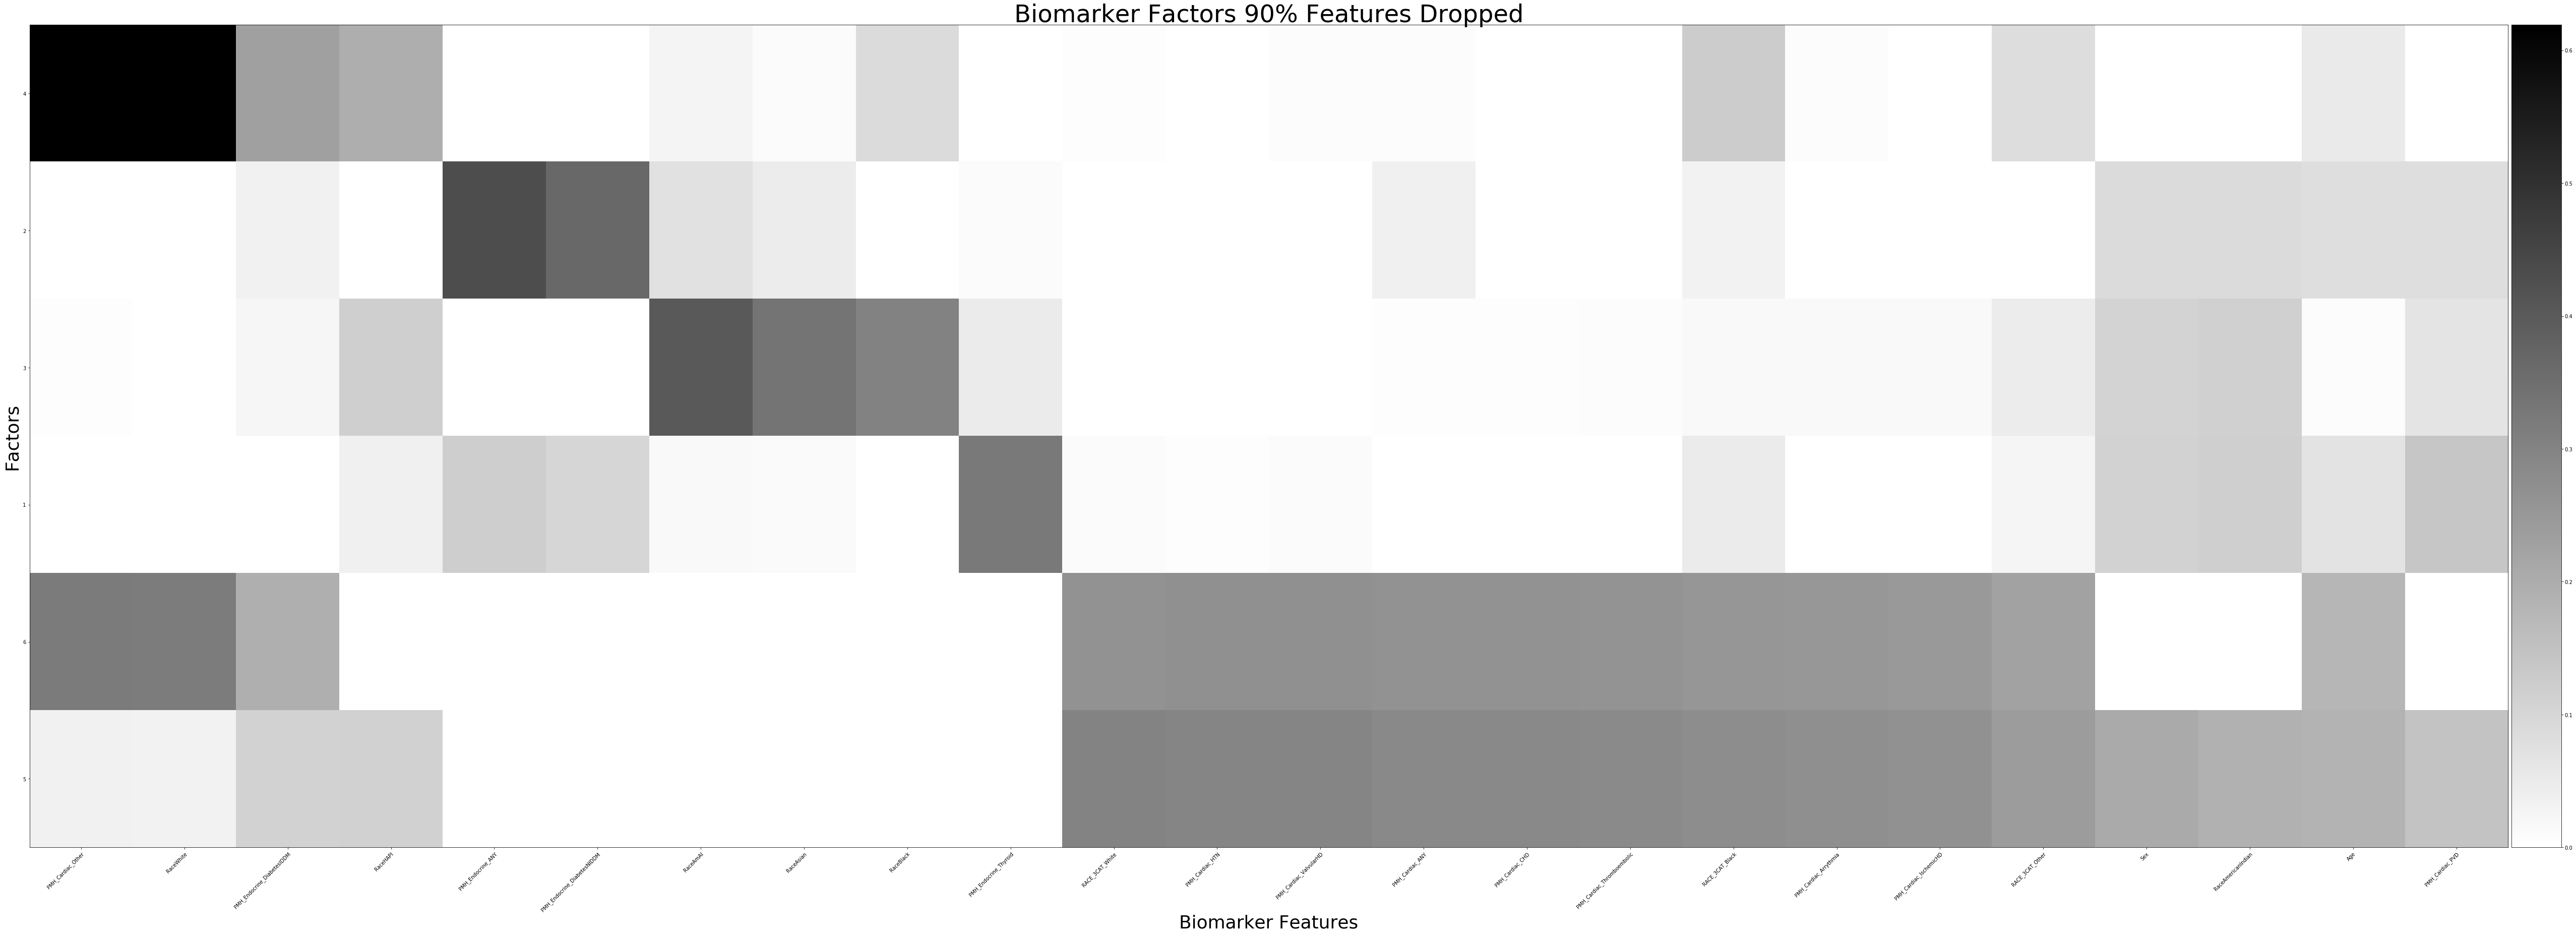

In [38]:
percent=[0,90]
for ii,p in enumerate(percent):
    A_features_dropped, features_dropped, dropped_feature_names = drop_features(orig.biomarkers,bmbases,feature_names,p)
    plt.figure(figsize=(90,30))
    nmf_bases_heatmap(features_dropped, col_labels=feature_names, sort=True, ax=None,
            cbar_kw={}, cbarlabel="", xlab='Biomarker Features', ylab='Factors', aspect='auto',
            title='Biomarker Factors {}% Features Dropped'.format(p))
    txt = str(sorted(dropped_feature_names))

In [6]:
def sigmoid(x, beta1, beta2):
    return beta1/(1+np.exp(-beta2*x))

func = sigmoid

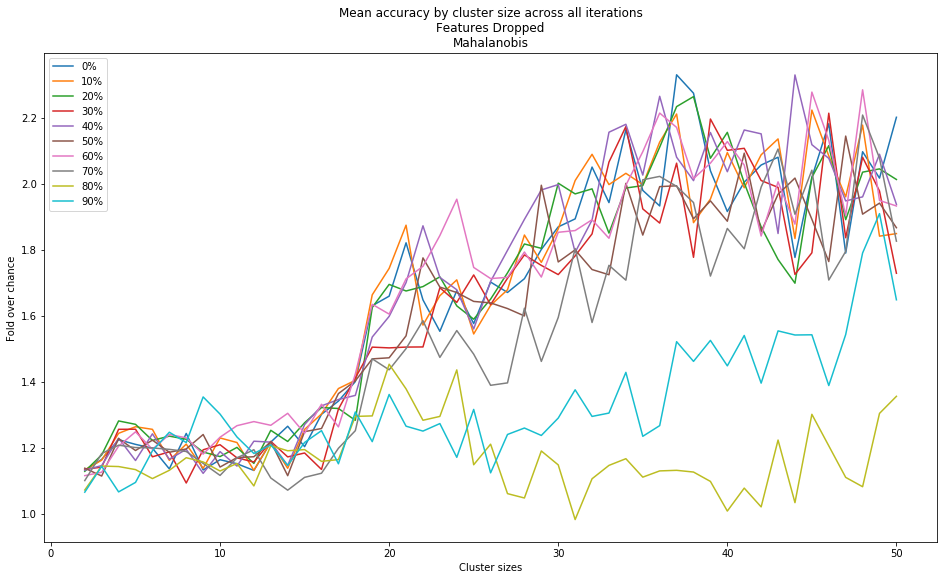

In [7]:
percent = [0,10,20,30,40,50,60,70,80,90]
for ii,p in enumerate(percent):
    path = '/Users/ahyeon/Desktop/activ/results/features_dropped/bm_features_dropped/mahalanobis/bm_features_dropped_result_{}.h5'.format(p)
    f = h5py.File(path, 'r')
    score = f['score'][:]
    norm_score = f['norm_score'][:]
    cluster_sizes = f['cluster_sizes'][:]
    cluster_sizes.shape
    score = score.mean(axis=0).mean(axis=1)
    norm_score = norm_score.mean(axis=0).mean(axis=1)
    plt.rcParams["figure.figsize"] = [16,9]
    cmap = plt.get_cmap("tab10")
    plt.plot(cluster_sizes, score/norm_score, label='{}%'.format(p), color=cmap(ii))
    plt.title("Mean accuracy by cluster size across all iterations\nFeatures Dropped\nMahalanobis")
    plt.xlabel("Cluster sizes")
    plt.ylabel("Fold over chance")
    plt.legend()

In [11]:
percent = [0,10,20,30,40,50,60,70,80,90]
percent2 = [90]

for ii,p in enumerate(percent):
    path = '/Users/ahyeon/Desktop/activ/results/features_dropped/bm_features_dropped/mahalanobis/bm_features_dropped_result_{}.h5'.format(p)
    results = UmapClusteringResults(path)
    print(results)
    
    
    nclust = results.cluster_sizes.shape[0]
    
    mean_results = results.adjust().T.mean(axis=1)
    
    plt.rcParams["figure.figsize"] = [16,9]
    cmap = plt.get_cmap("tab10")
    plt.title("Mean accuracy by cluster size across\nall iterations and dimension size\nFeatures Dropped")
    plt.xlabel("Cluster sizes", )
    plt.ylabel("Fold over chance")
    plt.plot(results.cluster_sizes,mean_results, '.', label='{}%'.format(p), color=cmap(ii))
    popt, pcov = curve_fit(func, results.cluster_sizes, mean_results)
    plt.plot(results.cluster_sizes, func(results.cluster_sizes, *popt), color=cmap(ii))
#     plt.boxplot(results.cluster_sizes, mean_results, whis=[25,75])
    limit = np.ones(nclust)*popt[0]
    plt.plot(results.cluster_sizes, limit)
    shift = 1.96*np.sqrt(pcov[0][0])*np.ones(nclust)
    plt.fill_between(results.cluster_sizes, limit+shift, limit-shift, alpha = 0.2)

    
#     plt.legend()

IndexError: tuple index out of range